# Reproduce: Stabalizing Feedback Controls for quantum systems

Robert Johansson (robert@riken.jp). Following Mirrahimi and Handel (arxiv quanth-ph/0510066 2005)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

## Section 5: Two-qubit systems

In Sec. Mirrahimi and Handel, the authors give a feedback control law that stabalizes two interesting entangled qubit states. Here we will implement this feedback law and demonstrate it numerically.

In Eq. 5.1 in Mirrahimi and Handel, the quantum filtering equation for a two-qubit system is given by

$$
d\rho_t(t) = 
- i u_1(t) [\sigma_y^{(1)}, \rho_t(t)] dt
- i u_2(t) [\sigma_y^{(2)}, \rho_t(t)] dt
-\frac{1}{2} [F_z, [F_z, \rho_t(t)]]dt
+ \sqrt{\eta} \left\{F_z\rho_t(t) + \rho_t(t)F_z - 2{\rm Tr}[F_z \rho_t(t)]\rho_t(t)\right\} dW_t
$$

or $\mathcal{D}$ and $\mathcal{H}$ we can write:

$$
d\rho_t(t) =
- i u_1(t) [\sigma_y^{(1)}, \rho_t(t)] dt
- i u_2(t) [\sigma_y^{(2)}, \rho_t(t)] dt
+ \mathcal{D}[F_z] \rho_t(t) dt
+ \sqrt{\eta} \mathcal{H}[F_z] \rho_t(t) dW_t
$$

### Implementation in QuTiP

In QuTiP we write the stochastic master equation on the form:

$$ d\rho(t) = -i[H, \rho(t)] dt + \mathcal{D}[B] \rho(t) dt + D_{1}[A]\rho(t) dt + D_{2}[A]\rho(t) dW$$

With $H = 0$, $B = F_z$, and $A = F_z$, we can identify:

$$ D_{1}[A]\rho_t(t) = 
-i u_1(t) [\sigma_y^{(1)}, \rho_t(t)]
-i u_2(t) [\sigma_y^{(2)}, \rho_t(t)]
+ \mathcal{D}[A] \rho_t(t)
$$

$$ D_{2}[A]\rho_t(t) = \sqrt{\eta} \mathcal{H}[A] \rho_t(t) $$


### Setup operators and states

In [2]:
sx1, sy1, sz1 = [tensor(op, identity(2)) for op in (sigmax(), sigmay(), sigmaz())]
sx2, sy2, sz2 = [tensor(identity(2), op) for op in (sigmax(), sigmay(), sigmaz())]

In [3]:
Fx, Fy, Fz = sx1 + sx2, sy1 + sy2, sz1 + sz2

In [4]:
psi_ud = tensor(basis(2, 1), basis(2, 0))
psi_du = tensor(basis(2, 0), basis(2, 1))

psi_s = (psi_ud + psi_du).unit()
psi_a = (psi_ud - psi_du).unit()

The purpose of Sec. 5 in Mirrahimi and Handel is to give a feedback control law that stabalize the following two entangled qubit states:

In [5]:
rho_s = psi_s * psi_s.dag()
rho_a = psi_a * psi_a.dag()

In [6]:
# problem parameters
eta = 0.4
gamma = 0.15

In [7]:
# simulation paramters
T = 25
nsteps = 1000
nsubsteps = 100
times = np.linspace(0, T, nsteps)
ntraj = 1

In [8]:
# a random initial state
rho0 = tensor(ket2dm(rand_ket(2, density=1)), ket2dm(rand_ket(2, density=1)))

In [9]:
# expectation value operators
e_ops = [sx1, sy1, sz1, sx2, sy2, sz2]

In [10]:
# Hamiltonian, deterministic and stochastic collapse operators
H = 0 * Fz
c_ops = []
sc_ops = [Fz]

To implement the control laws for the two target states in QuTiP we need to defined the d1 and d2 functions for the stochastic master equation:

### $D_1$

$$ D_{1}[F_z]\rho_t(t) 
=  -i u_1(t) [\sigma_y^{(1)}, \rho_t(t)] -i u(t) [\sigma_y^{(2)}, \rho_t(t)]  + \mathcal{D}[F_z] \rho_t(t) 
=  u_1(t) L[\sigma_y^{(1)}] \rho_t(t) + u_2(t) L[\sigma_y^{(2)}] \rho_t(t) + \mathcal{D}[F_z] \rho_t(t) $$

In [11]:
from qutip.expect import expect_rho_vec

In [12]:
# precompute required matrices and vectors used in u_a_t and u_s_t
L_sy1_data = liouvillian(sy1, []).data
L_sy2_data = liouvillian(sy2, []).data

rho_s_vec = mat2vec(rho_s.full()).ravel()
rho_s_mat = vec2mat(rho_s_vec)

rho_a_vec = mat2vec(rho_a.full()).ravel()
rho_a_mat = vec2mat(rho_a_vec)

# define functions for the control laws. Theorem 5 in Mirrahimi and Handel

_u_a_prev_region = 0
def u_a_t(A, rho_vec):
    """Feedback control from Mirrahimi and Handel:
    Compute and return the u_1 and u_2 functions for
    the case when the target state is rho_a.
    """
    global _u1_prev_region
    
    tr_rr = np.diag(np.dot(rho_a_mat, vec2mat(rho_vec))).sum().real
    
    if tr_rr < gamma / 2:
        _u1_a_prev_region = 0
        u_1 = 1
        u_2 = 0
    
    elif tr_rr >= gamma or _u_a_prev_region == 1:
        _u1_a_prev_region = 1
        
        x =  - L_sy1_data * rho_vec 
        y = np.diag(np.dot(vec2mat(x), rho_a_mat)).sum().real
        u_1 = 1 - y

        x = - L_sy2_data * rho_vec 
        y = np.diag(np.dot(vec2mat(x), rho_a_mat)).sum().real
        u_2 = 1 - y

    else:
        u_1 = 1
        u_2 = 0
        
    return u_1, u_2


_u_s_prev_region = 0
def u_s_t(A, rho_vec):
    """Feedback control from Mirrahimi and Handel.
    Compute and return the u_1 and u_2 functions for
    the case when the target state is rho_s.
    """
    global _u1_prev_region
    
    tr_rr = np.diag(np.dot(rho_s_mat, vec2mat(rho_vec))).sum().real
    
    if tr_rr < gamma / 2:
        _u1_s_prev_region = 0
        u_1 = 1
        u_2 = 0
    
    elif tr_rr >= gamma or _u_s_prev_region == 1:
        _u1_s_prev_region = 1
        
        x =  - L_sy1_data * rho_vec
        y = np.diag(np.dot(vec2mat(x), rho_s_mat)).sum().real
        u_1 = 1 - y

        x = - L_sy2_data * rho_vec
        y = np.diag(np.dot(vec2mat(x), rho_s_mat)).sum().real
        u_2 = - 1 - y

    else:
        u_1 = 1
        u_2 = 0
        
    return u_1, u_2

    
def d1_s(t, rho_vec, A, args):
    # rho_s as target
    u_1, u_2 = u_s_t(A, rho_vec)

    return (u_1 * L_sy1_data * rho_vec +
            u_2 * L_sy2_data * rho_vec +
            A[7] * rho_vec)

def d1_a(t, rho_vec, A, args):
    # rho_a as target
    u_1, u_2 = u_a_t(A, rho_vec)

    return (u_1 * L_sy1_data * rho_vec +
            u_2 * L_sy2_data * rho_vec +
            A[7] * rho_vec)

### $D_2$

$$ D_{2}[F_z]\rho_t(t) = \sqrt{\eta} \mathcal{H}[F_z] \rho_t(t) 
= \sqrt{\eta}(F_z\rho_t(t)  + \rho_t(t) F_z - \mathrm{Tr}[F_z\rho_t(t)  + \rho_t(t) F_z] \rho_t(t))
\rightarrow \sqrt{\eta} \left((A_L +  A_R^\dagger)\rho_t - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_t] \rho_t\right)
$$

In [13]:
def d2(t, rho_vec, A, args):
    n_sum = A[0] + A[3]
    e1 = expect_rho_vec(n_sum, rho_vec, False)
    return [np.sqrt(eta) * (n_sum * rho_vec - e1 * rho_vec)]

### Simulation

In [14]:
# solve using the d2 implementation that stabilized rho_s
result_s = smesolve(H, rho0, times, [], sc_ops, e_ops, 
                    ntraj=ntraj, nsubsteps=nsubsteps, d1=d1_s, d2=d2,
                    distribution='normal',
                    options=Options(store_states=True, average_states=True))

Total run time: 105.36s


In [15]:
# solve using the d2 implementation that stabilized rho_a
result_a = smesolve(H, rho0, times, [], sc_ops, e_ops, 
                    ntraj=ntraj, nsubsteps=nsubsteps, d1=d1_a, d2=d2,
                    distribution='normal',
                    options=Options(store_states=True, average_states=True))

Total run time: 108.19s


### Functions for visualizing the results

In [16]:
def visualize_dynamics(result, rho_f):
    
    fig, axes = plt.subplots(1, 3, figsize=(16,5))

    ## Expectation values of the collective degrees of freedom
    axes[0].plot(times, result.expect[0] + result.expect[3], 'r', lw=2, label=r'$\langle F_x\rangle$')
    axes[0].plot(times, result.expect[1] + result.expect[4], 'b', lw=2, label=r'$\langle F_y\rangle$')
    axes[0].plot(times, result.expect[2] + result.expect[5], 'k', lw=2, label=r'$\langle F_z\rangle$')

    axes[0].plot(times, np.ones_like(times) * expect(Fx, rho_f), 'r--', lw=2)
    axes[0].plot(times, np.ones_like(times) * expect(Fy, rho_f), 'b--', lw=2)
    axes[0].plot(times, np.ones_like(times) * expect(Fz, rho_f), 'k--', lw=2)

    axes[0].set_ylim(-2.1, 2.1)
    axes[0].set_xlim(0, times.max())
    axes[0].set_xlabel('time', fontsize=12)
    axes[0].legend(loc=4);    

    ## Expectation values of qubit 1
    axes[1].plot(times, result.expect[0], 'r', lw=2, label=r'$\langle\sigma_x^{(1)}\rangle$')
    axes[1].plot(times, result.expect[1], 'b', lw=2, label=r'$\langle\sigma_y^{(1)}\rangle$')
    axes[1].plot(times, result.expect[2], 'k', lw=2, label=r'$\langle\sigma_z^{(1)}\rangle$')

    axes[1].plot(times, np.ones_like(times) * expect(sx1, rho_f), 'r--', lw=2)
    axes[1].plot(times, np.ones_like(times) * expect(sy1, rho_f), 'b--', lw=2)
    axes[1].plot(times, np.ones_like(times) * expect(sz1, rho_f), 'k--', lw=2)

    axes[1].set_ylim(-1.1, 1.1)
    axes[1].set_xlim(0, times.max())
    axes[1].set_xlabel('time', fontsize=12)
    axes[1].legend(loc=4);

    ## Expectation values of qubit 2
    axes[2].plot(times, result.expect[3], 'r', lw=2, label=r'$\langle\sigma_x^{(2)}\rangle$')
    axes[2].plot(times, result.expect[4], 'b', lw=2, label=r'$\langle\sigma_y^{(2)}\rangle$')
    axes[2].plot(times, result.expect[5], 'k', lw=2, label=r'$\langle\sigma_z^{(2)}\rangle$')

    axes[2].plot(times, np.ones_like(times) * expect(sx2, rho_f), 'r--', lw=2)
    axes[2].plot(times, np.ones_like(times) * expect(sy2, rho_f), 'b--', lw=2)
    axes[2].plot(times, np.ones_like(times) * expect(sz2, rho_f), 'k--', lw=2)

    axes[2].set_ylim(-1.1, 1.1)
    axes[2].set_xlim(0, times.max())
    axes[2].set_xlabel('time', fontsize=12)
    axes[2].legend(loc=4)

    return fig, axes

In [17]:
def visualize_dynamics_blochsphere(result, rho_f):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})

    b = Bloch(fig=fig, axes=axes[0])
    b.add_points(result.expect[:3], meth='l')
    b.make_sphere()

    b = Bloch(fig=fig, axes=axes[1])
    b.add_points(result.expect[3:], meth='l')
    b.make_sphere()
    
    return fig, axes

In [18]:
def visualize_fidelity(result, rho_target):
        
    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    f = [fidelity(rho_target, rho) for rho in result.states]
    c = [concurrence(rho) for rho in result.states]
    ax.plot(result.times, f, 'r', lw=2, label=r'fidelity')
    ax.plot(result.times, c, 'b', lw=2, label=r'concurrence')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, times.max())
    ax.set_xlabel('time', fontsize=12)
    ax.legend(loc=4)
    
    return fig, ax

### Stabilizing $\rho_s$

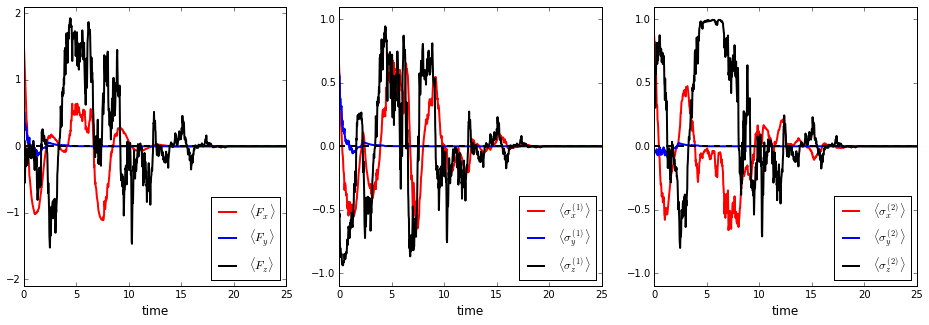

In [19]:
visualize_dynamics(result_s, rho_s);

In [20]:
rho = result_s.states[-1].tidyup(atol=1e-3)
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.49999941  0.49999848  0.        ]
 [ 0.          0.49999848  0.49999943  0.        ]
 [ 0.          0.          0.          0.        ]]

In [21]:
#target
rho_s

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5  0.5  0. ]
 [ 0.   0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

In [22]:
# fidelity at final time in simulation
fidelity(rho_s, rho)

0.9999989773045586

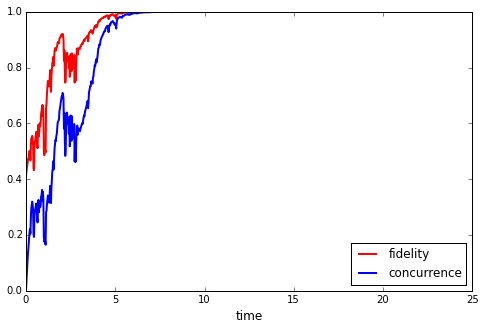

In [23]:
# evolution of fidelity from the random initial state
visualize_fidelity(result_a, rho_a);

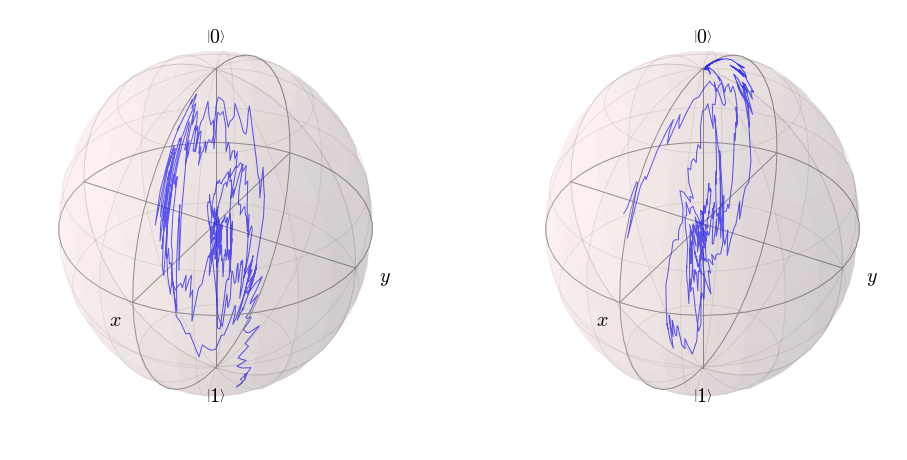

In [24]:
visualize_dynamics_blochsphere(result_s, rho_s);

### Stabilizing $\rho_a$

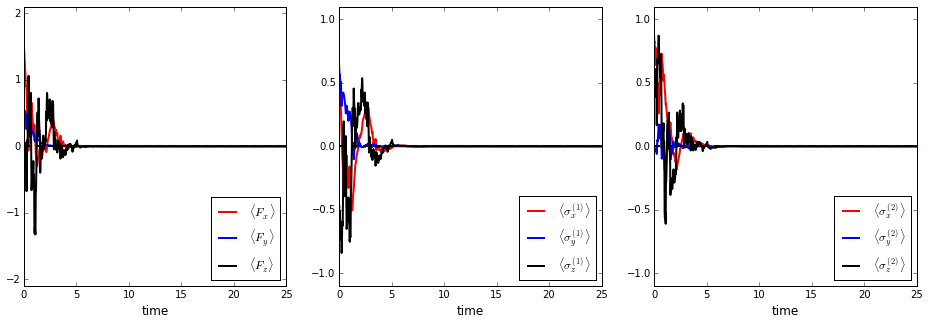

In [25]:
visualize_dynamics(result_a, rho_a);

In [26]:
rho = result_a.states[-1].tidyup(atol=1e-3)
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

In [27]:
rho_a

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

In [28]:
# fidelity at final time in simulation
fidelity(rho_a, rho)

1.0000000234736035

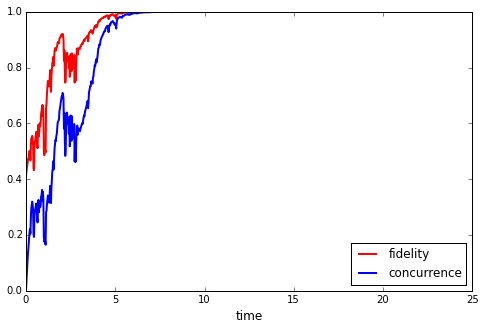

In [29]:
# evolution of fidelity from the random initial state
visualize_fidelity(result_a, rho_a);

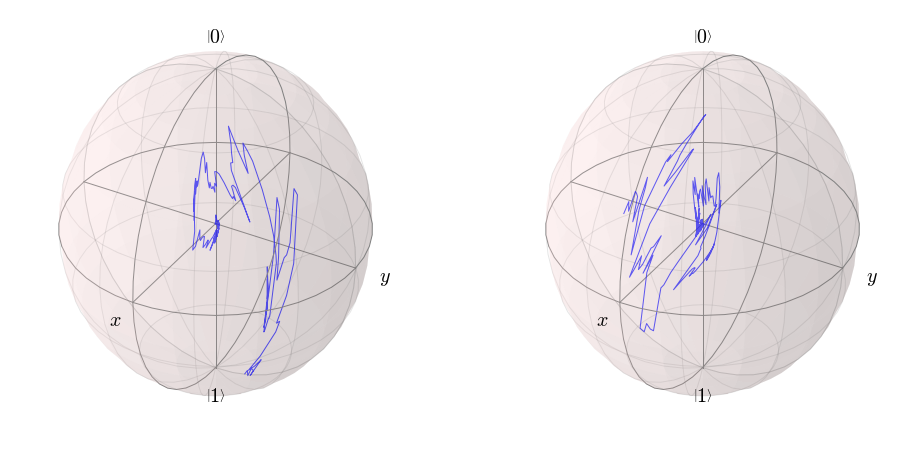

In [30]:
visualize_dynamics_blochsphere(result_a, rho_a);

## Versions

In [31]:
from qutip.ipynbtools import version_table

version_table()